In [1]:
# Import necessary libraries
import pickle as pkl
import pickle
import numpy as np
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold # type: ignore
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import langid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


/Users/makchanna128gmail.com/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Loading Dataset

In [2]:
feature_questions, target_intents = pkl.load(open("dataset.pkl", "rb"))

## Model

### Split data

In [3]:
# Split the data into training and validation sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(feature_questions, target_intents, test_size=0.2, random_state=42)


In [4]:
# Convert y_train and y_test to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### SGDClassifier model

In [5]:
# Initialize the SGDClassifier with specified parameters
sgd_clf = SGDClassifier(penalty='l2', alpha=0.001, loss='log_loss', random_state=42)


In [6]:
# Define the parameter grid with corrected 'loss' value
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [1000, 5000],
    'learning_rate': ['optimal', 'adaptive', 'constant', 'invscaling'],
    'eta0': [0.01, 0.1, 1.0],  # Include eta0 values
    'loss': ['log_loss']  # Corrected loss parameter
}


#### Grid Search CV to do hyperparameters tuning

In [7]:
# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1,error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
             estimator=SGDClassifier(alpha=0.001, loss='log_loss',
                                     random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.01, 0.1, 1.0],
                         'learning_rate': ['optimal', 'adaptive', 'constant',
                                           'invscaling'],
                         'loss': ['log_loss'], 'max_iter': [1000, 5000],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='accuracy')

In [8]:
# Retrieve the best model after grid search
best_sgd_clf = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'alpha': 0.0001, 'eta0': 1.0, 'learning_rate': 'adaptive', 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2'}


#### Create early stopping class 

In [9]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = np.inf
        self.counter = 0
    
    def early_stop(self, current_score):
        if current_score < self.best_score:
            self.best_score = current_score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [10]:
# Train the best model with early stopping
patience = 5
best_val_loss = np.inf
patience_counter = 0
max_epochs = 100

# Initialize EarlyStopping with a patience of 5 epochs
early_stopping = EarlyStopping(patience=patience)

# Initialize lists for storing training and testing scores
train_scores = []
test_scores = []

# Training loop with early stopping
for epoch in range(max_epochs):
    best_sgd_clf.fit(X_train, y_train)
    train_accuracy = best_sgd_clf.score(X_train, y_train)
    test_accuracy = best_sgd_clf.score(X_test, y_test)
    train_scores.append(train_accuracy)  # Append training accuracy
    test_scores.append(test_accuracy)    # Append testing accuracy

    # Early stopping based on validation accuracy improvement
    if early_stopping.early_stop(test_accuracy):
        print(f"Early stopping at epoch {epoch}")
        break

Early stopping at epoch 5


### Evaluation

In [11]:
# Make predictions on the test set
y_pred = best_sgd_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.896551724137931
Precision: 0.9586206896551724
Recall: 0.896551724137931
F1 Score: 0.9014778325123153


### Save the model using pickle

In [12]:
with open('sgdclassifier_model_testing.pt', 'wb') as file: pickle.dump(best_sgd_clf, file)

### Learning Curve

In [13]:
# Analyze learning curve with the best model
train_sizes, train_scores, val_scores = learning_curve(
    best_sgd_clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1,scoring='accuracy'
)


In [14]:
# Print learning curve details
for train_size, cv_train_scores, cv_test_scores in zip(train_sizes, train_scores, val_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average validation accuracy is {cv_test_scores.mean():.2f}")


9 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.63
18 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.81
27 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.82
36 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.83
46 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.86
55 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.86
64 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.90
73 samples were used to train the model
The average train accuracy is 1.00
The average validation accuracy is 0.95
82 samples were used to train the model
The average train accuracy is 1.00
The av

In [15]:
# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

### Plot

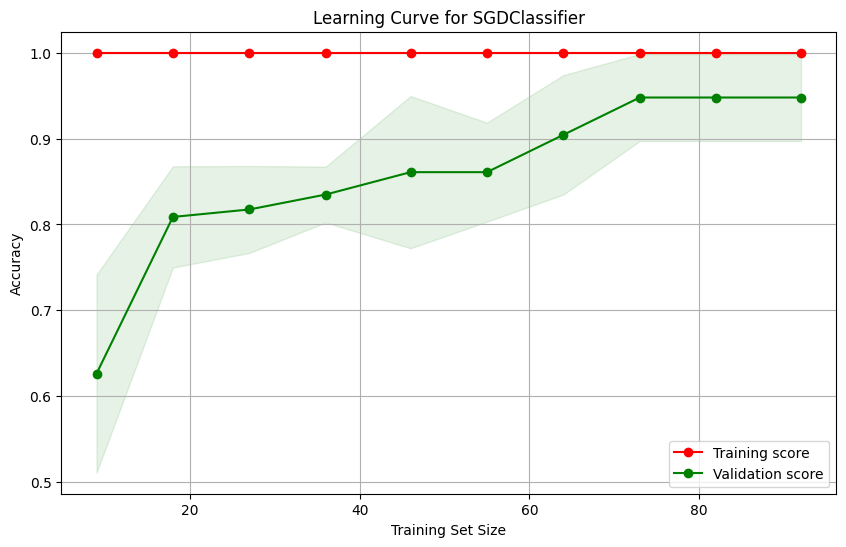

In [16]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')

# Fill the area between curves to show variance
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')

# Set plot labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for SGDClassifier')
plt.legend(loc='best')
plt.grid()
plt.show()

## Response

In [17]:
class Prediction:
    _instance = None
    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls, *args, **kwargs)
            cls._instance.intitialize()
        return cls._instance
    
    def intitialize(self):
        self.transformer_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
        self.dict_intent_entity = pkl.load(open("dict_intent_entity.pkl","rb")) # change to your path
    
    def identify_entity(self,question,list_entities):
        
        _list_entities = list_entities
        _question = question
        _question = _question.lower()
        _count_entities = []
        _store_entities = []
        _len_entities = []
        _store_index = []
        for idx,entities in enumerate(_list_entities):
            _count_entities.append(0)
            _store_entities.append(entities)
            _len_entities.append(len(entities))
            _store_index.append(idx)
            for entity in entities:
                if entity in _question:
                    _count_entities[idx] = _count_entities[idx] + 1
        _count_entities = np.array(_count_entities)
        max_value = np.max(_count_entities)
        
        if max_value == 0:
            return None
        idx_max = _count_entities == max_value
        _store_entities = np.array(_store_entities,dtype=object)
        _max_entities = _store_entities[idx_max]
        _store_max_len = np.array(_len_entities)
        _store_max_len = _store_max_len[idx_max]
        min_id = np.argmin(_store_max_len)
        
        return _max_entities[min_id]

    def identify_language(self,question):
        return langid.classify(question)[0]
    def get_answer(self,model,question):
        _intent = model.predict(self.transformer_model.encode([question]))
        _dict_entities = self.dict_intent_entity[_intent[0]]
        _list_entities = list(_dict_entities.keys())
        _identity = self.identify_entity(question,_list_entities)
        try:
            _identity = tuple(_identity)
        except:
            return "I'm sorry, I don't have ability to answer this question yet."
        _answer = _dict_entities[_identity][self.identify_language(question)]
        if type(_answer) == list:
            idx = np.random.randint(0,len(_answer))
            return _answer[idx]
        return _answer
        return "I'm sorry, I don't have ability to answer this question yet."

In [18]:
prediction = Prediction()
input_question = "bye"
prediction.get_answer(best_sgd_clf,input_question)

"I'm sorry, I don't have ability to answer this question yet."